Setting up imports

In [44]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from example.models import CNNModel, CNNModel2, CNNModel3
from example.datasets import FashionMNISTDataset

Adding custom hyper-parameters

In [45]:
learning_rate = 0.15
momentum = 0.9
num_epochs = 20

Set up a device for pytorch calculations

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading datasets, training dataset from kaggle and test dataset from kaggle

In [47]:
train_dataloader = torch.utils.data.DataLoader(dataset=FashionMNISTDataset(file="model_data/fashion-mnist_train.csv"), batch_size=1024, pin_memory=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(dataset=FashionMNISTDataset(file="model_data/fashion-mnist_test.csv"), batch_size=1024, pin_memory=True, num_workers=4)

Add loss function - Cross Entropy Loss

In [48]:
criterion = nn.CrossEntropyLoss()

Model training method where we update loss each epoch and X_train record

In [49]:
def train_model(model, loss_each_epoch, print_loss = False):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_dataloader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()


            running_loss += loss.item()

        loss_each_epoch.append(running_loss)
        if print_loss:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")

We compare all of our models to check which one is performing the best, we plot
data of loss over epochs

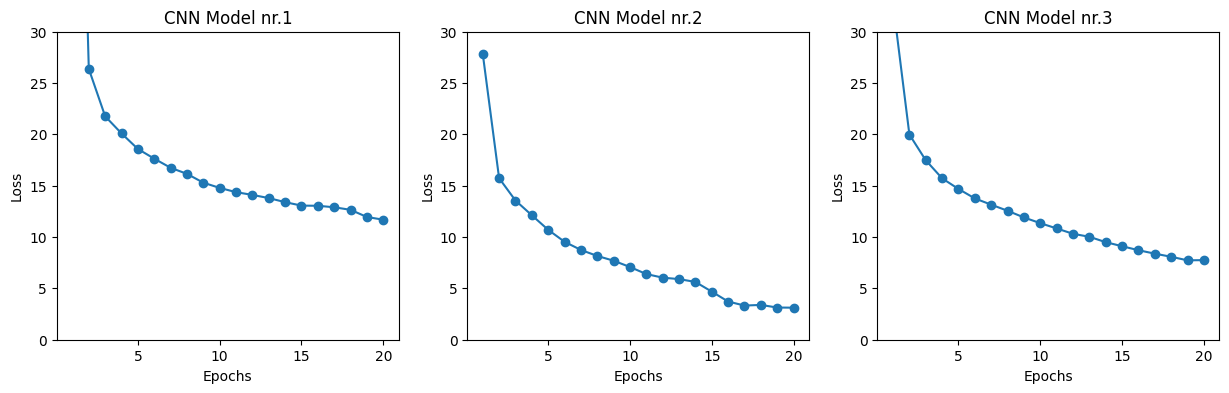

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [50]:
models = [CNNModel(), CNNModel2(), CNNModel3()]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, model in enumerate(models):
    model_loss_each_epoch = []
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    train_model(model, model_loss_each_epoch)

    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(8, 5))
    axes[idx].set_title(f"CNN Model nr.{idx + 1}")
    axes[idx].plot(epochs, model_loss_each_epoch, marker='o')
    axes[idx].set_ylim(0, 30)
    axes[idx].set_xlabel('Epochs')
    axes[idx].set_ylabel('Loss')

plt.tight_layout()
plt.show()

We are checking model accuracy basing on test dataset

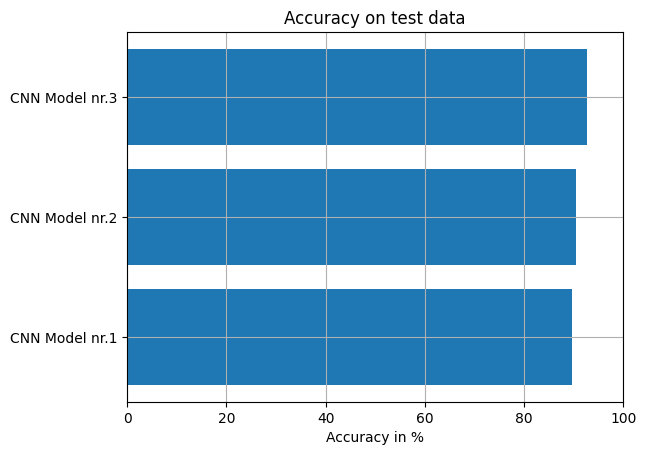

In [51]:
models_accuracy = []
models_predictions = [[], [], []]
models_all_labels = [[], [], []]

for idx, model in enumerate(models):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            models_predictions[idx].append(predicted.cpu().numpy())
            models_all_labels[idx].append(labels.cpu().numpy())
    accuracy = 100 * correct / total
    models_accuracy.append(accuracy)

plt.barh(["CNN Model nr.1", "CNN Model nr.2", "CNN Model nr.3"], models_accuracy)
plt.title("Accuracy on test data")
plt.xlabel("Accuracy in %")
plt.xlim(0, 100)
plt.grid()
plt.show()

Viewing models correct answers and mistakes on sklearn ConfusionMatrix

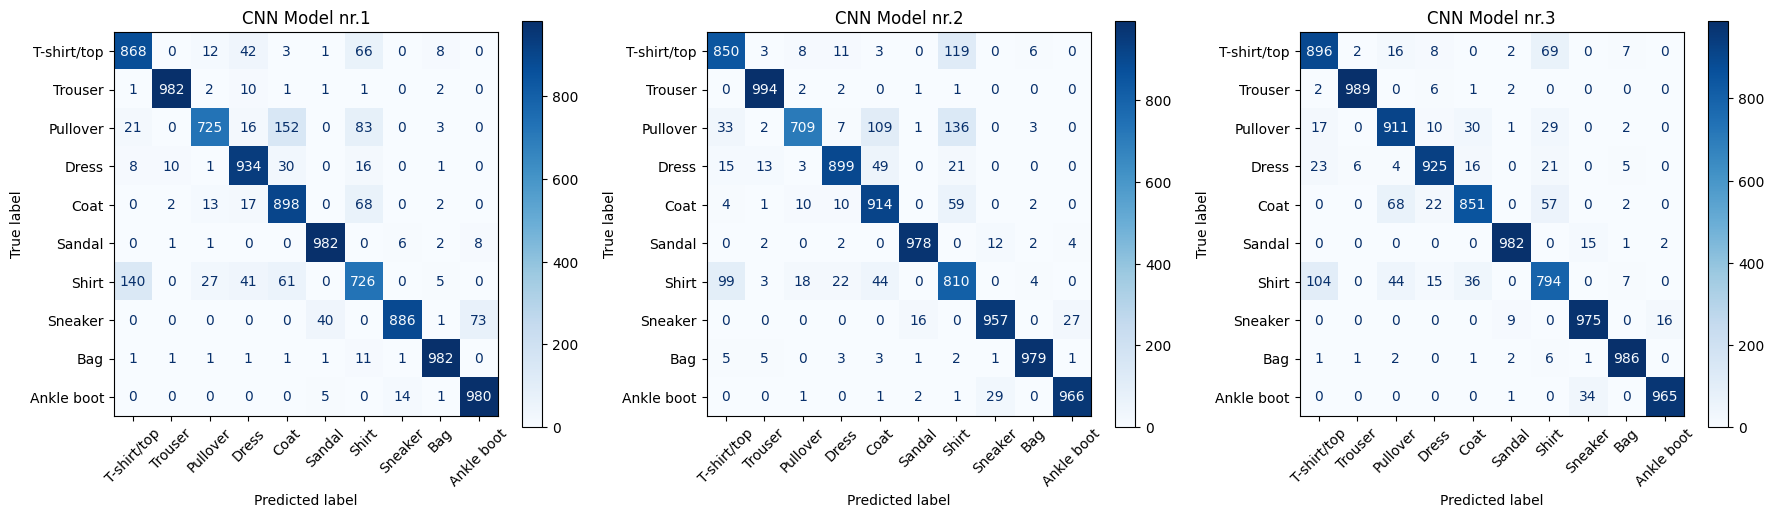

In [52]:

label_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, _ in enumerate(models):
    y_true = np.concatenate(models_all_labels[idx])
    y_pred = np.concatenate(models_predictions[idx])

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_names[i] for i in range(10)])
    disp.plot(cmap='Blues', ax=axes[idx], xticks_rotation=45)
    axes[idx].set_title(f"CNN Model nr.{idx+1}")

plt.tight_layout()
plt.show()
